In [ ]:
!pip -q install regex datasets transformers accelerate

import math
import random
from collections import Counter
import regex as re
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


Почему-то прохо работала api для загрузки корпусов, взял 3 архива с сайта с Пушкином. Ниже код просто для ипорта с гугл диска.

In [ ]:
import os
import zipfile
import glob

def load_texts_from_dataverse_zip(
    zip_path: str,
    extract_dir: str = "/content/dataverse_extracted",
    encoding: str = "utf-8",
    max_files: int | None = None,
    min_chars: int = 20,
):
    os.makedirs(extract_dir, exist_ok=True)

    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(extract_dir)

    txt_paths = sorted(glob.glob(os.path.join(extract_dir, "**", "*.txt"), recursive=True))

    if max_files is not None:
        txt_paths = txt_paths[:max_files]

    texts = []
    for p in txt_paths:
        try:
            with open(p, "r", encoding=encoding) as f:
                t = f.read().strip()
            if len(t) >= min_chars:
                texts.append(t)
        except UnicodeDecodeError:
            try:
                with open(p, "r", encoding="cp1251") as f:
                    t = f.read().strip()
                if len(t) >= min_chars:
                    texts.append(t)
            except Exception:
                pass
    print(len(texts))
    return texts, txt_paths, extract_dir


In [ ]:
test_bayron_texts, train_paths, train_dir = load_texts_from_dataverse_zip(
    "/content/dataverse_train/byron_corpus/byron_corpus.zip",
    extract_dir="/content/content/dataverse_train/bt",
    max_files=20000)
print(test_bayron_texts)

**Источник**:    
regex-паттерн из GPT-2 tokenizer (OpenAI, encoder.py).    
**Смысл:**  
выделяем слова/числа/пунктуацию + сохраняем робел как часть токена (" leading space")

**Упрощённый byte-level BPE**   
    - База словаря: 0..255 (все байты)
    - Претокенизация regex'ом (как в GPT-2)
    - BPE-мерджи учим на частотах пар
    - Спецтокены добавляем отдельными id
  

500
100
100
500
vocab_size = 300
vocab_size = 400
vocab_size = 500
vocab_size = 600
vocab_size = 700
vocab_size = 800
vocab_size = 900
vocab_size = 1000
compression ratio (tokens/bytes): 0.310030678620613
avg tokens/word: 3.404109290569984
avg tokens/word (top 10% frequent words): 1.964108997142658
compression ratio (tokens/bytes): 0.3011291009799744
avg tokens/word: 3.3969917958067457
avg tokens/word (top 10% frequent words): 1.9970267591674926


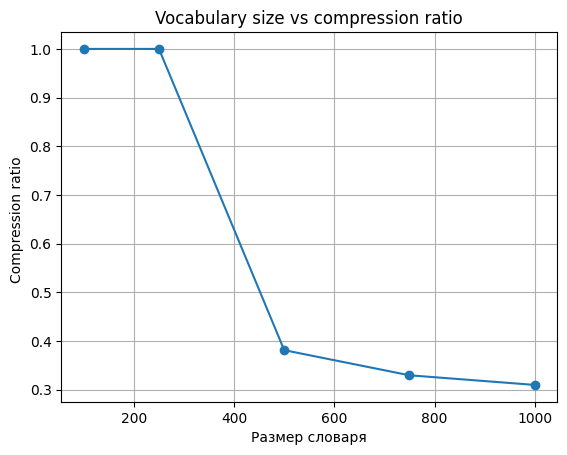

100
Пушкин: доля токенов, не использованных ни разу = 0.365
Всего токенов в словаре: 1000 использовано: 635 не использовано: 365


In [ ]:

def get_gpt2_pretoken_pattern():
    return re.compile(
        r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+"""
    )

class SimpleByteBPE:
    def __init__(self, vocab_size: int, special_tokens=None, pattern=None):
        self.vocab_size = int(vocab_size)
        self.pattern = pattern or get_gpt2_pretoken_pattern()

        self.special_tokens = special_tokens or ["<pad>", "<bos>", "<eos>", "<unk>"]

        # id -> bytes (для decode)
        self.vocab_bytes = {i: bytes([i]) for i in range(256)}

        # спецтокены
        self.special_to_id = {}
        self.id_to_special = {}

        # мерджи: (id0, id1) -> new_id
        self.pair_to_id = {}
        self.id_to_pair = {}

        # ранги мерджей: чем меньше, тем раньше применяем
        self.ranks = {}

        self._init_specials()

    def _init_specials(self):
        next_id = max(self.vocab_bytes) + 1
        for tok in self.special_tokens:
            self.special_to_id[tok] = next_id
            self.id_to_special[next_id] = tok
            # храним байты спецтокенов просто для полноты
            self.vocab_bytes[next_id] = tok.encode("utf-8")
            next_id += 1

    def pretokenize(self, text: str):
        return self.pattern.findall(text)

    def fit(self, texts, verbose=False):

        # считаем частоты претокенов в байтах
        token_freq = Counter()
        for t in texts:
            for piece in self.pretokenize(t):
                token_freq[tuple(piece.encode("utf-8"))] += 1

        next_id = max(self.vocab_bytes) + 1

        while len(self.vocab_bytes) < self.vocab_size:
            pair_counts = Counter()
            for word, freq in token_freq.items():
                # word: tuple[int] (байты)
                for i in range(len(word) - 1):
                    pair_counts[(word[i], word[i + 1])] += freq

            if not pair_counts:
                break

            (best_a, best_b), best_cnt = pair_counts.most_common(1)[0]

            # Если пара встречается очень редко, можно остановиться
            if best_cnt < 2:
                break

            best_pair = (best_a, best_b)

            # регистрируем merge
            self.pair_to_id[best_pair] = next_id
            self.id_to_pair[next_id] = best_pair
            self.ranks[best_pair] = len(self.ranks)

            # строим bytes для нового токена
            self.vocab_bytes[next_id] = self.vocab_bytes[best_a] + self.vocab_bytes[best_b]

            # заменяем best_pair во всех словах
            new_freq = Counter()
            for word, freq in token_freq.items():
                new_word = []
                i = 0
                while i < len(word):
                    if i < len(word) - 1 and (word[i], word[i + 1]) == best_pair:
                        new_word.append(next_id)
                        i += 2
                    else:
                        new_word.append(word[i])
                        i += 1
                new_freq[tuple(new_word)] += freq
            token_freq = new_freq

            next_id += 1

            if verbose and len(self.vocab_bytes) % 100 == 0:
                print("vocab_size =", len(self.vocab_bytes))

    def _bpe_merge(self, ids):

        # ids: list[int] (обычно байты 0..255)
        # применяем мерджи пока возможно.
        tokens = ids[:]
        while True:
            if len(tokens) < 2:
                break

            # ищем лучший pair по рангу (минимальный rank)
            best_pair = None
            best_rank = None
            for i in range(len(tokens) - 1):
                p = (tokens[i], tokens[i + 1])
                r = self.ranks.get(p)
                if r is None:
                    continue
                if best_rank is None or r < best_rank:
                    best_rank = r
                    best_pair = p

            if best_pair is None:
                break

            new_tokens = []
            i = 0
            while i < len(tokens):
                if i < len(tokens) - 1 and (tokens[i], tokens[i + 1]) == best_pair:
                    new_tokens.append(self.pair_to_id[best_pair])
                    i += 2
                else:
                    new_tokens.append(tokens[i])
                    i += 1
            tokens = new_tokens

        return tokens

    def encode(self, text: str, add_special_tokens=False):
        out = []
        if add_special_tokens:
            out.append(self.special_to_id["<bos>"])

        for piece in self.pretokenize(text):
            b = list(piece.encode("utf-8"))
            out.extend(self._bpe_merge(b))

        if add_special_tokens:
            out.append(self.special_to_id["<eos>"])
        return out

    def decode(self, token_ids):
        buf = b""
        for tid in token_ids:
            # спецтокены пропускаем в decode (обычно так удобнее)
            if tid in self.id_to_special:
                continue
            buf += self.vocab_bytes.get(tid, self.vocab_bytes[self.special_to_id["<unk>"]])
        return buf.decode("utf-8", errors="replace")



def load_texts_for_domains(max_train=500, max_test=100, seed=42):
  # толстой
    train_texts, train_paths, train_dir = load_texts_from_dataverse_zip(
    "/content/drive/MyDrive/publications_txt.zip",
    extract_dir="/content/dataverse_train",
    max_files=max_train)
  # байрон
    test_bayron_texts, train_paths, train_dir = load_texts_from_dataverse_zip(
    "/content/drive/MyDrive//byron_corpus.zip",
    extract_dir="/content/content/dataverse_train",
    max_files=max_test)
  # русские элегии
    test_eleg_texts, train_paths, train_dir = load_texts_from_dataverse_zip(
    "/content/drive/MyDrive/elegies_corpus.zip",
    extract_dir="/content/dataverse_train",
    max_files=max_test)

    # held-out смешанный
    mixed_test = (test_bayron_texts[:max_test//2] + test_eleg_texts[:max_test//2])
    random.shuffle(mixed_test)
    print(len(train_texts))
    return train_texts, test_bayron_texts, test_eleg_texts, mixed_test

train_texts, test_wiki, test_web, mixed_test = load_texts_for_domains()

# обучаем токенайзер
bpe = SimpleByteBPE(
    vocab_size=1000,
    special_tokens=["<pad>", "<bos>", "<eos>", "<unk>"]
)
bpe.fit(train_texts, verbose=True)


def compression_ratio(tokenizer: SimpleByteBPE, texts):
    total_tokens = 0
    total_bytes = 0
    for t in texts:
        total_tokens += len(tokenizer.encode(t, add_special_tokens=False))
        total_bytes += len(t.encode("utf-8"))
    return total_tokens / max(1, total_bytes)

def avg_tokens_per_word(tokenizer: SimpleByteBPE, texts):

    # среднее количество токенов на слово
    word_re = re.compile(r"\p{L}+|\p{N}+")
    total_words = 0
    total_tokens = 0
    for t in texts:
        words = word_re.findall(t)
        total_words += len(words)
        total_tokens += len(tokenizer.encode(t, add_special_tokens=False))
    return total_tokens / max(1, total_words)

def avg_tokens_per_word_top10pct_freq(tokenizer: SimpleByteBPE, texts):

    # среднее кол-во токенов на слово для топ 10

    word_re = re.compile(r"\p{L}+|\p{N}+")
    freq = Counter()
    for t in texts:
        freq.update([w.lower() for w in word_re.findall(t)])

    if not freq:
        return 0.0

    # берём верхние 10% по частоте
    uniq = len(freq)
    top_k = max(1, int(math.ceil(0.10 * uniq)))
    top_words = set([w for w, _ in freq.most_common(top_k)])

    total_words = 0
    total_tokens = 0
    for t in texts:
        words = [w.lower() for w in word_re.findall(t)]
        sel = [w for w in words if w in top_words]
        if not sel:
            continue
        total_words += len(sel)
        # оцениваем токены по тексту, составленному из выбранных слов
        total_tokens += len(tokenizer.encode(" ".join(sel), add_special_tokens=False))

    return total_tokens / max(1, total_words)

def report_domain(tokenizer, name, texts):
    cr = compression_ratio(tokenizer, texts)
    tpw = avg_tokens_per_word(tokenizer, texts)
    tpw_top = avg_tokens_per_word_top10pct_freq(tokenizer, texts)
    print("compression ratio (tokens/bytes):", cr)
    print("avg tokens/word:", tpw)
    print("avg tokens/word (top 10% frequent words):", tpw_top)

report_domain(bpe, "TEST: Байрон", test_wiki)
report_domain(bpe, "TEST: Эллегии", test_web)

vocab_sizes = [100, 250, 500, 750, 1000]
cr_values = []

# можно взять подвыборку для ускорения
train_small = train_texts
test_small = mixed_test

for vs in vocab_sizes:
    tok = SimpleByteBPE(vocab_size=vs, special_tokens=["<pad>", "<bos>", "<eos>", "<unk>"])
    tok.fit(train_small, verbose=False)
    cr_values.append(compression_ratio(tok, test_small))

plt.figure()
plt.plot(vocab_sizes, cr_values, marker="o")
plt.xlabel("Размер словаря")
plt.ylabel("Compression ratio ")
plt.title("Vocabulary size vs compression ratio")
plt.grid(True)
plt.show()


def load_pushkin_texts(max_items=100):
  test_pushkin_texts, train_paths, train_dir = load_texts_from_dataverse_zip(
    "/content/drive/MyDrive/texts.zip",
    extract_dir="/content/dataverse_train",
    max_files=max_items)
  return test_pushkin_texts


pushkin_texts = load_pushkin_texts()

# считаем, какие id реально встретились
used_ids = set()
for t in pushkin_texts:
    used_ids.update(bpe.encode(t, add_special_tokens=False))

all_token_ids = set(bpe.vocab_bytes.keys())
# спецтокены тоже считаем частью словаря
unused = all_token_ids - used_ids

unused_share = len(unused) / max(1, len(all_token_ids))
print("Пушкин: доля токенов, не использованных ни разу =", unused_share)
print("Всего токенов в словаре:", len(all_token_ids), "использовано:", len(used_ids), "не использовано:", len(unused))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LMDataset(Dataset):

    # Делаем из текстов один длинный поток токенов и режем на блоки.

    def __init__(self, tokenizer: SimpleByteBPE, texts, block_size=128):
        ids = []
        for t in texts:
            ids.extend(tokenizer.encode(t, add_special_tokens=True))
        self.data = torch.tensor(ids, dtype=torch.long)
        self.block_size = block_size

    def __len__(self):
        return max(0, (len(self.data) - 1) // self.block_size)

    def __getitem__(self, idx):
        start = idx * self.block_size
        x = self.data[start:start + self.block_size]
        y = self.data[start + 1:start + self.block_size + 1]
        return x, y

class TinyTransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model=256, nhead=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(2048, d_model)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=4*d_model, dropout=dropout, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, x):

        B, T = x.shape
        pos = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
        h = self.tok_emb(x) + self.pos_emb(pos)

        # causal mask (запрещаем смотреть вправо)
        mask = torch.triu(torch.ones(T, T, device=x.device), diagonal=1).bool()
        h = self.encoder(h, mask=mask)
        logits = self.lm_head(h)
        return logits


block_size = 128
train_ds = LMDataset(bpe, train_texts[:3000], block_size=block_size)
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, drop_last=True)

vocab_size_actual = max(bpe.vocab_bytes.keys()) + 1
model = TinyTransformerLM(vocab_size_actual).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
loss_fn = nn.CrossEntropyLoss()

model.train()
for epoch in range(2):
    total_loss = 0.0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits.reshape(-1, logits.size(-1)), y.reshape(-1))
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: loss={total_loss/len(train_dl):.4f}")

@torch.no_grad()
def generate(model, tokenizer: SimpleByteBPE, prompt: str, max_new_tokens=50):
    model.eval()
    ids = tokenizer.encode(prompt, add_special_tokens=True)
    x = torch.tensor(ids, dtype=torch.long, device=device).unsqueeze(0)

    for _ in range(max_new_tokens):
        logits = model(x[:, -block_size:])
        next_id = torch.argmax(logits[0, -1], dim=-1).item()
        x = torch.cat([x, torch.tensor([[next_id]], device=device)], dim=1)

    return tokenizer.decode(x[0].tolist())

print("GEN:", generate(model, bpe, "Привет, я", max_new_tokens=60))


Epoch 1: loss=4.2301
Epoch 2: loss=3.6458

GEN: Привет, яОБОБЫКИНИКАЯ ЛИТЕРАТУРА.                          17
— Полинька, сказалъ онъ, что онъ, какъ будто не
похнулъ, что онъ,

